In [1]:
import pandas as pd

# Load the dataset
train_path = r"C:\Users\HP PROBOOK\Downloads\DailyDelhiClimateTrain.csv"
test_path = r"C:\Users\HP PROBOOK\Downloads\DailyDelhiClimateTrain.csv"

# Load the CSV file
df1 = pd.read_csv(train_path)
df2 = pd.read_csv(test_path)
data = pd.concat([df1, df2], ignore_index=True)
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [2]:
df = data.set_index('date')[['meantemp']]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.8
validate_size = 0.1
test_size = 0.1

train_data, temp_data = train_test_split(df, train_size=train_size, shuffle=False)
validate_data, test_data = train_test_split(temp_data, test_size=test_size / (validate_size + test_size), shuffle=False)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data only and transform the splits
train_data['meantemp'] = scaler.fit_transform(train_data[['meantemp']])
validate_data['meantemp'] = scaler.transform(validate_data[['meantemp']])
test_data['meantemp'] = scaler.transform(test_data[['meantemp']])

# Output the sizes of the splits
print(f"Train size: {train_data.shape}")
print(f"Validate size: {validate_data.shape}")
print(f"Test size: {test_data.shape}")

# Display the training data
print(train_data.head())

Train size: (2339, 1)
Validate size: (292, 1)
Test size: (293, 1)
            meantemp
date                
2013-01-01 -2.032420
2013-01-02 -2.381689
2013-01-03 -2.413034
2013-01-04 -2.211532
2013-01-05 -2.569758


In [4]:
import numpy as np

def create_sequences(data, sequence_length):
    """
    Converts a time series into sequences for LSTM input.
    
    Parameters:
        data (array-like): The time series data (1D array or DataFrame column).
        sequence_length (int): The number of time steps in each sequence.
        
    Returns:
        X, y: Arrays of input sequences (X) and corresponding outputs (y).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'sequence_length' steps
        seq = data[i:i + sequence_length]
        # The output is the step immediately following the sequence
        label = data[i + sequence_length]
        X.append(seq)
        y.append(label)
    
    return np.array(X), np.array(y)

# Example usage:
sequence_length = 10  # Example sequence length
X_train, y_train = create_sequences(train_data['meantemp'].values, sequence_length)
X_validate, y_validate = create_sequences(validate_data['meantemp'].values, sequence_length)
X_test, y_test = create_sequences(test_data['meantemp'].values, sequence_length)

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (2329, 10)
y_train shape: (2329,)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First GRU layer with 64 units
    GRU(64, activation='tanh'),  # Second GRU layer with 32 units
    Dense(8, activation='relu'),  # Dense layer with 8 neurons and ReLU activation
    Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')  # Using MAE as loss

# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=40,  # Number of epochs
    batch_size=32,  # Batch size
    validation_data=(X_validate, y_validate),  # Validation data
    verbose=2  # Display training progress
)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

# Print evaluation metrics
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"RMSE: {rmse}")


Epoch 1/40


C:\Users\HP PROBOOK\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 - 6s - 86ms/step - loss: 0.7310 - val_loss: 0.4520
Epoch 2/40
73/73 - 1s - 9ms/step - loss: 0.2834 - val_loss: 0.2057
Epoch 3/40
73/73 - 1s - 8ms/step - loss: 0.2202 - val_loss: 0.2012
Epoch 4/40
73/73 - 1s - 8ms/step - loss: 0.2173 - val_loss: 0.1987
Epoch 5/40
73/73 - 1s - 8ms/step - loss: 0.2139 - val_loss: 0.1965
Epoch 6/40
73/73 - 1s - 8ms/step - loss: 0.2105 - val_loss: 0.1913
Epoch 7/40
73/73 - 1s - 9ms/step - loss: 0.2077 - val_loss: 0.1906
Epoch 8/40
73/73 - 1s - 8ms/step - loss: 0.2041 - val_loss: 0.1887
Epoch 9/40
73/73 - 1s - 8ms/step - loss: 0.2011 - val_loss: 0.1843
Epoch 10/40
73/73 - 1s - 9ms/step - loss: 0.1988 - val_loss: 0.1813
Epoch 11/40
73/73 - 1s - 10ms/step - loss: 0.1963 - val_loss: 0.1789
Epoch 12/40
73/73 - 1s - 10ms/step - loss: 0.1936 - val_loss: 0.1757
Epoch 13/40
73/73 - 1s - 11ms/step - loss: 0.1918 - val_loss: 0.1740
Epoch 14/40
73/73 - 1s - 10ms/step - loss: 0.1894 - val_loss: 0.1734
Epoch 15/40
73/73 - 1s - 11ms/step - loss: 0.1874 - val_loss: 0

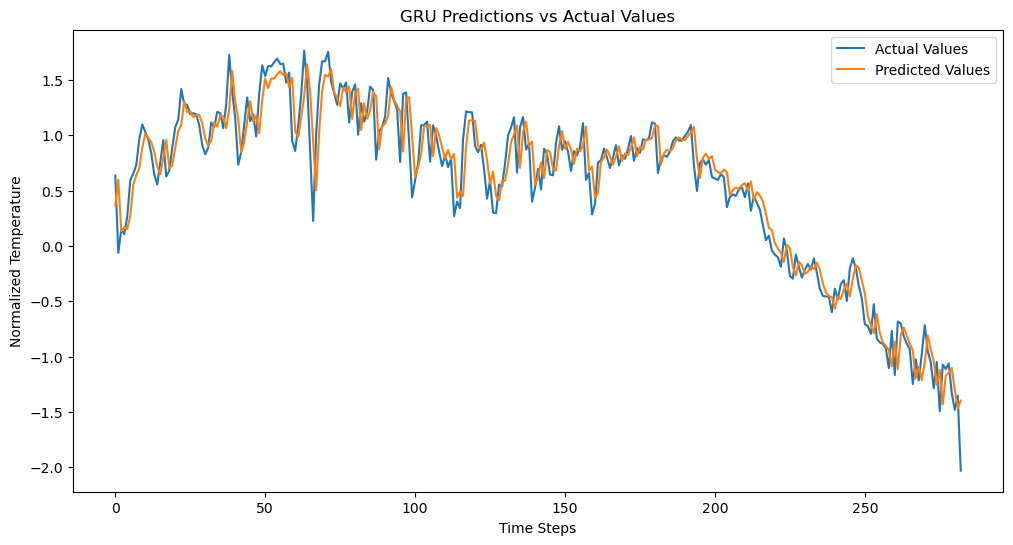

In [6]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values')  # Actual values
plt.plot(y_pred, label='Predicted Values')  # Predicted values
plt.legend()
plt.title("GRU Predictions vs Actual Values")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Temperature")
plt.show()
